In [1]:
import os 
import random 
import shutil 
import joblib
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd  
import cv2

from sklearn.model_selection import train_test_split  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, RocCurveDisplay

## Data Preparation

### Data Loading

In [2]:
# path to the dataset 
data = "/kaggle/input/garden-dataset1"
 
# List of all classes in the dataset directory
classes = os.listdir(data) 
print("Classes: {}".format(classes)) 
# Set the test split ratio
test_split = 0.2
 
# Create separate directories for the training and test sets
# the train directory
train_dir = 'training'
shutil.rmtree('training', ignore_errors=True) 
os.mkdir('training') 

# the test directory
test_dir = 'testing'
shutil.rmtree('testing', ignore_errors=True) 
os.mkdir('testing')   

# Split the data into training and validation sets
for class_name in classes:
    class_dir = os.path.join(data, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Get the list of images in the class directory
    images = os.listdir(class_dir)
    num_images = len(images)
    num_test = int(test_split * num_images)

    # Move images to the training directory
    for img in images[:-num_test]:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(train_class_dir, img)
        shutil.copy(src_path, dst_path)

    # Move images to the test directory
    for img in images[-num_test:]:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(test_class_dir, img)
        shutil.copy(src_path, dst_path)

Classes: ['Cassava', 'Grass', 'Maize', 'Sugarcane']


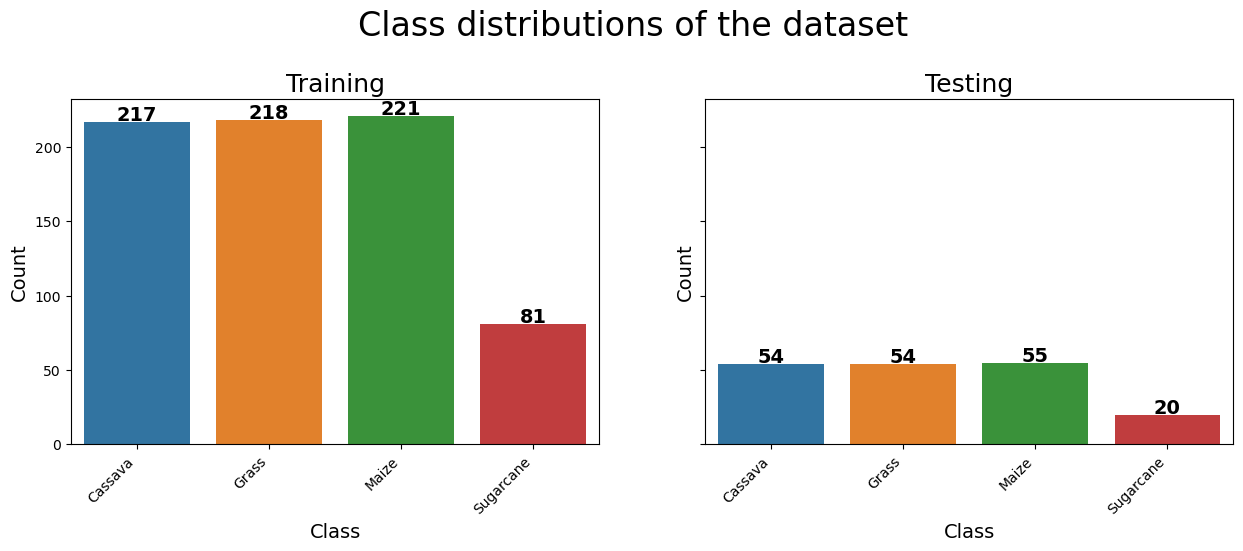

In [3]:
def get_class_distribution(directory):
    class_labels = []
    for root, dirs, files in os.walk(directory):
        if len(files) > 0:
            class_name = os.path.basename(root)
            class_labels.extend([class_name] * len(files))

    class_labels = np.array(class_labels)
    unique_labels, label_indices = np.unique(class_labels, return_inverse=True)
    class_counts = np.bincount(label_indices)
    return unique_labels, class_counts

def plot_class_distribution(data, title, ax):
    labels = np.arange(len(data[1]))
    counts = data[1]
    class_names = data[0]
    
    ax = sns.barplot(ax=ax, x=labels, y=counts) 
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xticks(labels)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(height, (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=14, color='black', xytext=(0, 5), textcoords='offset points', weight='bold')

train_labels = get_class_distribution(train_dir)
test_labels = get_class_distribution(test_dir) 

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Class distributions of the dataset', fontsize=24)
plt.subplots_adjust(top=0.8)

plot_class_distribution(train_labels, 'Training', axes[0]) 
plot_class_distribution(test_labels, 'Testing', axes[1])

plt.show()


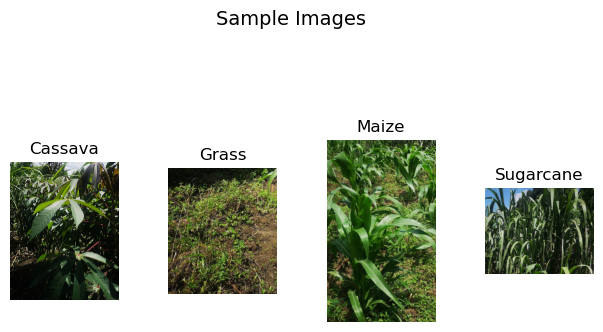

In [4]:
from glob import glob
# Set the paths to the train, and test directories
train_data = "training"
test_data = "testing"
 
sample_images = [glob("training/Cassava/*")[0],
                 glob("training/Grass/*")[0],
                 glob("training/Maize/*")[0],
                 glob("training/Sugarcane/*")[0]]
 
    
def plot_images(images, names): 
    fig, axs = plt.subplots(1, 4)    
    fig.tight_layout(pad=0.5)
    plt.suptitle('Sample Images', fontsize=14)

    for i, ax in enumerate(axs.flat):
        # Load and display the image
        if isinstance(images[i], str): 
            image = plt.imread(images[i])
        else:  # Image array provided
            image = images[i]
        ax.imshow(image)
        ax.axis('off')

        # Add the title
        ax.set_title(names[i])

    plt.show()
    
plot_images(sample_images, classes)

### Feature Extraction

In [5]:
def extract_color_histogram(image):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Compute the histogram for each channel (Hue, Saturation, Value)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    
    # Normalize the histograms
    cv2.normalize(hist_hue, hist_hue, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(hist_saturation, hist_saturation, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(hist_value, hist_value, 0, 1, cv2.NORM_MINMAX)
    
    # Concatenate the histograms into a single feature vector
    feature_vector = np.concatenate([hist_hue, hist_saturation, hist_value]).flatten()
    
    return feature_vector

def extract_features_from_folder(folder_path, feature_extractor):
    features = []
    labels = []
    
    class_folders = os.listdir(folder_path)
    
    for class_folder in class_folders:
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            class_label = class_folder
            
            image_files = os.listdir(class_path)
            
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                
                # Load the image
                image = cv2.imread(image_path)
                
                # Extract color histogram features
                extracted_features = feature_extractor(image)
                
                features.append(extracted_features)
                labels.append(class_label) 
    return features, labels

### The KNN Classifier

In [6]:
def train_knn_classifier(train_features, train_labels, n_neighbors):
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(train_features, train_labels)
    return knn

In [7]:
def evaluate_classifier(classifier, test_features, test_labels, classes):
    # Predict labels for the test features
    predictions = classifier.predict(test_features)

    # Generate the classification report
    report = classification_report(test_labels, predictions)

    # Generate the confusion matrix
    cm = confusion_matrix(test_labels, predictions)

    # Print the classification report
    print("Classification Report for KNN Classifier\n", report)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix for KNN Classifier') 
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.show()

In [8]:
def compute_roc_curve(classifier, test_features, test_labels, classes):
    # Convert test labels to one-hot encoded format
    test_labels_encoded = label_binarize(test_labels, classes=classes)

    # Compute class probabilities
    class_probabilities = classifier.predict_proba(test_features)

    # Compute ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(test_labels_encoded[:, i], class_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute overall ROC curve
    overall_fpr, overall_tpr, _ = roc_curve(test_labels_encoded.ravel(), class_probabilities.ravel())
    overall_auc = auc(overall_fpr, overall_tpr)

    # Plot the ROC curves
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot(overall_fpr, overall_tpr, label=f'Overall (AUC = {overall_auc:.2f})', linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for KNN Classifier')
    plt.legend(loc='lower right')
    plt.show()

In [9]:
# Extract color histogram features and labels from the training folder
train_color_features, train_labels = extract_features_from_folder(train_data, extract_color_histogram)

# Extract color histogram features and labels from the testing folder
test_color_features, test_labels = extract_features_from_folder(test_data, extract_color_histogram)

# Create a DataFrame from the features and labels 
feature_columns = [f"Feature{i+1}" for i in range(len(train_color_features[0]))]
df_train = pd.DataFrame(train_color_features, columns=feature_columns)
df_train.insert(0, "Label", train_labels)
df_train.head()

,Label,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature759,Feature760,Feature761,Feature762,Feature763,Feature764,Feature765,Feature766,Feature767,Feature768
0,Cassava,0.614140,0.010780,0.011745,0.014418,0.009111,0.035840,0.039230,0.005074,0.033717,...,0.000634,0.000562,0.000377,0.000353,0.000161,0.000066,0.000185,9.094947e-12,0.000036,0.005285
1,Cassava,0.028713,0.003234,0.005824,0.007149,0.006811,0.019810,0.015745,0.007058,0.028541,...,0.004318,0.003584,0.002999,0.002949,0.002775,0.002650,0.002850,3.173063e-03,0.002874,0.022087
2,Cassava,0.088500,0.047809,0.048745,0.044261,0.061200,0.083325,0.071306,0.042579,0.101920,...,0.031040,0.034553,0.043205,0.044677,0.040886,0.044219,0.036609,2.276231e-02,0.018860,0.076703
3,Cassava,0.063942,0.013437,0.015225,0.020443,0.013625,0.034530,0.035034,0.007278,0.032875,...,0.020833,0.018835,0.015515,0.012360,0.008396,0.003804,0.002665,1.569115e-03,0.001420,0.008732
4,Cassava,0.016154,0.003739,0.006053,0.007446,0.009792,0.016572,0.016057,0.008867,0.021290,...,0.011362,0.010166,0.009848,0.010427,0.009829,0.009156,0.009493,9.287289e-03,0.010035,0.053425


Classification Report for KNN Classifier
               precision    recall  f1-score   support

     Cassava       1.00      0.94      0.97        54
       Grass       0.91      0.98      0.95        54
       Maize       0.98      0.91      0.94        55
   Sugarcane       0.87      1.00      0.93        20

    accuracy                           0.95       183
   macro avg       0.94      0.96      0.95       183
weighted avg       0.95      0.95      0.95       183



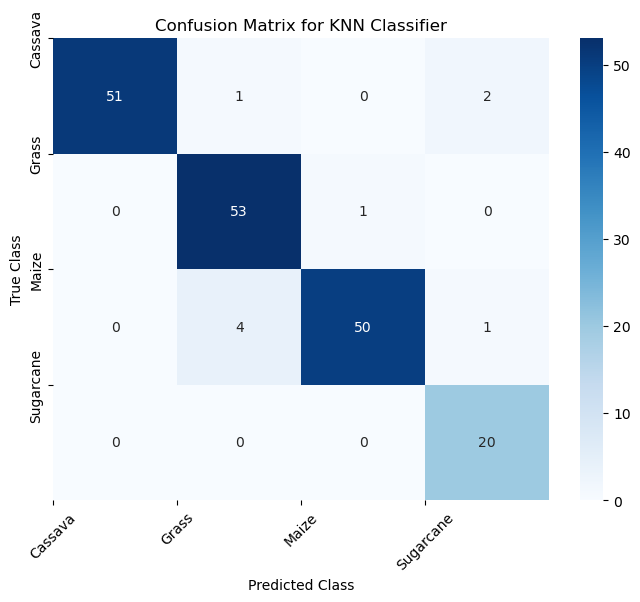

In [10]:
# Train KNN for color histogram features
knn_color = train_knn_classifier(train_color_features, train_labels, n_neighbors=3)
evaluate_classifier(knn_color, test_color_features, test_labels, classes)

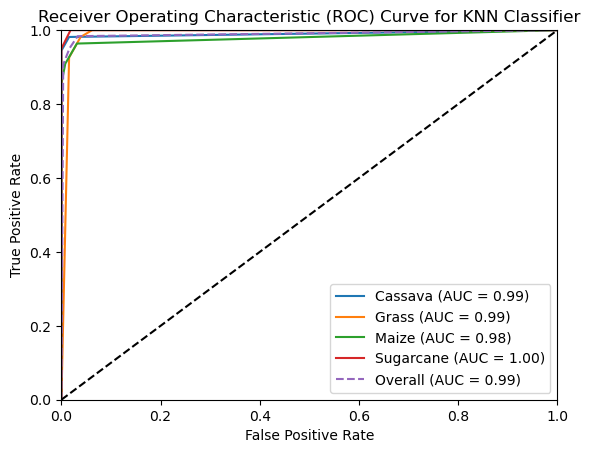

In [11]:
# Compute ROC curve
compute_roc_curve(knn_color, test_color_features, test_labels, classes) 

### Save the KNN Classifier

In [12]:
# Save the trained model 
joblib.dump(knn_color, 'knn_garden_model.pkl')

['knn_garden_model.pkl']